In [ ]:
import pandas as pd
from fredapi import Fred
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns # type: ignore
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
import shap

In [67]:
# Initialize FRED with your API key
fred = Fred(api_key='badde7b0bf5a6441f7da522af157a338 ')  # Replace with your key

# Define series IDs
series_ids = {
    'GDP': 'GDP',
    'Industrial_Production' : 'INDPRO',
    'Jobs': 'UNRATE',
    'Heavy_Vehicle_Sales': 'HTRUCKSSAAR',
    'Recession': 'USREC'
}

# Fetch data
data = {}
for name, series_id in series_ids.items():
    data[name] = fred.get_series(series_id)

# Combine into a DataFrame
df = pd.DataFrame(data)

# Resample to month-end
df = df.resample('ME').last()

if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

In [ ]:
# Interpolate GDP from quarterly to monthly
df['GDP'] = df['GDP'].interpolate(method='linear')

# Calculate GDP growth rate and NASDAQ return
df['GDP_Growth'] = df['GDP'].pct_change() * 100
df['GDP_Growth'] = df['GDP_Growth'].ffill()
#df['NASDAQ_Return'] = df['Stock_Market'].pct_change() * 100
#df['NASDAQ_Return'] = df['NASDAQ_Return'].ffill()

#df['Jobs'] = df['Jobs'].diff()

# Trim to where all core series have data
df = df.dropna(subset=['GDP', 'Industrial_Production', 'Jobs', 'Heavy_Vehicle_Sales', 'Recession'])

# Add recession targets for different horizons
df['Recession_Next_3M'] = df['Recession'].shift(-3)
df['Recession_Next_6M'] = df['Recession'].shift(-6)
df['Recession_Next_12M'] = df['Recession'].shift(-12)


# Cut off at last full month, dynamically based on current date
#today = datetime.today()  # Gets current date and time
#last_week = today - timedelta(days=7)  # One week back
#last_full_month = last_week.replace(day=1) - timedelta(days=1)  # End of previous month
#df_full = df.loc[:last_full_month.strftime('%Y-%m-%d')].copy()


df_full = df

# Convert row names (index) to a column called 'Date'
df_full = df_full.reset_index()
df_full = df_full.rename(columns={'index': 'Date'})  # If your index is unnamed

# Or if your index already has a name:
#df_full = df_full.reset_index()

# Now add the regime column
df_full['Regime'] = df_full['Date'].dt.year.apply(
    lambda x: '1960s to 1984' if x < 1985 else 
             '1977-1984' if x < 1985 and x >= 1977 else 
             '2000s'
)

In [44]:
# Training data for each horizon
df_train_3m = df_full.dropna(subset=['Recession_Next_3M'])
df_train_6m = df_full.dropna(subset=['Recession_Next_6M'])
df_train_12m = df_full.dropna(subset=['Recession_Next_12M'])

# Features
features = ['GDP', 'Industrial_Production', 'Jobs', 'Heavy_Vehicle_Sales']

# 3-month horizon
X_3m = df_train_3m[features]
y_3m = df_train_3m['Recession_Next_3M']
X_train_3m, X_test_3m, y_train_3m, y_test_3m = train_test_split(X_3m, y_3m, test_size=0.2, random_state=42)
scaler_3m = StandardScaler()
X_train_scaled_3m = scaler_3m.fit_transform(X_train_3m)
X_test_scaled_3m = scaler_3m.transform(X_test_3m)
model_3m = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model_3m.fit(X_train_scaled_3m, y_train_3m)

# 6-month horizon
X_6m = df_train_6m[features]
y_6m = df_train_6m['Recession_Next_6M']
X_train_6m, X_test_6m, y_train_6m, y_test_6m = train_test_split(X_6m, y_6m, test_size=0.2, random_state=42)
scaler_6m = StandardScaler()
X_train_scaled_6m = scaler_6m.fit_transform(X_train_6m)
X_test_scaled_6m = scaler_6m.transform(X_test_6m)
model_6m = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model_6m.fit(X_train_scaled_6m, y_train_6m)

# 12-month horizon
X_12m = df_train_12m[features]
y_12m = df_train_12m['Recession_Next_12M']
X_train_12m, X_test_12m, y_train_12m, y_test_12m = train_test_split(X_12m, y_12m, test_size=0.2, random_state=42)
scaler_12m = StandardScaler()
X_train_scaled_12m = scaler_12m.fit_transform(X_train_12m)
X_test_scaled_12m = scaler_12m.transform(X_test_12m)
model_12m = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model_12m.fit(X_train_scaled_12m, y_train_12m)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [45]:
# Evaluate models
print("3-Month Horizon Classification Report:")
print(classification_report(y_test_3m, model_3m.predict(X_test_scaled_3m)))
print("\n6-Month Horizon Classification Report:")
print(classification_report(y_test_6m, model_6m.predict(X_test_scaled_6m)))
print("\n12-Month Horizon Classification Report:")
print(classification_report(y_test_12m, model_12m.predict(X_test_scaled_12m)))

# Predict probabilities over the entire dataset
X_full_scaled_3m = scaler_3m.transform(df_full[features])
df_full.loc[:, 'Recession_Prob_3M'] = model_3m.predict_proba(X_full_scaled_3m)[:, 1]
X_full_scaled_6m = scaler_6m.transform(df_full[features])
df_full.loc[:, 'Recession_Prob_6M'] = model_6m.predict_proba(X_full_scaled_6m)[:, 1]
X_full_scaled_12m = scaler_12m.transform(df_full[features])
df_full.loc[:, 'Recession_Prob_12M'] = model_12m.predict_proba(X_full_scaled_12m)[:, 1]

# Predict probabilities for latest data
X_latest = df_full[features].tail(1)
latest_prob_3m = model_3m.predict_proba(scaler_3m.transform(X_latest))[0, 1]
latest_prob_6m = model_6m.predict_proba(scaler_6m.transform(X_latest))[0, 1]
latest_prob_12m = model_12m.predict_proba(scaler_12m.transform(X_latest))[0, 1]

3-Month Horizon Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       125
         1.0       0.88      0.94      0.91        16

    accuracy                           0.98       141
   macro avg       0.94      0.96      0.95       141
weighted avg       0.98      0.98      0.98       141


6-Month Horizon Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       121
         1.0       1.00      0.84      0.91        19

    accuracy                           0.98       140
   macro avg       0.99      0.92      0.95       140
weighted avg       0.98      0.98      0.98       140


12-Month Horizon Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       120
         1.0       0.94      0.79      0.86        19

    accuracy                           0.96       139
   macro


Predicted probabilities from 2025-08-31 00:00:00:
  Recession within 3 months: 7.00%
  Recession within 6 months: 6.00%
  Recession within 12 months: 3.00%


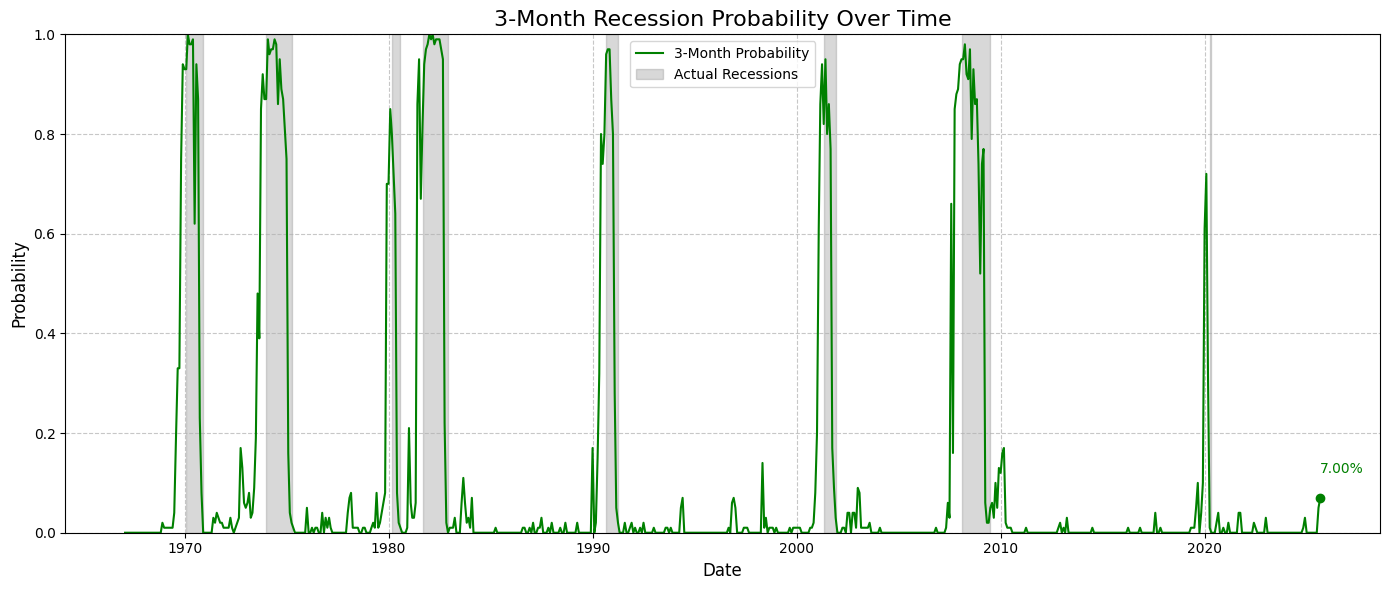

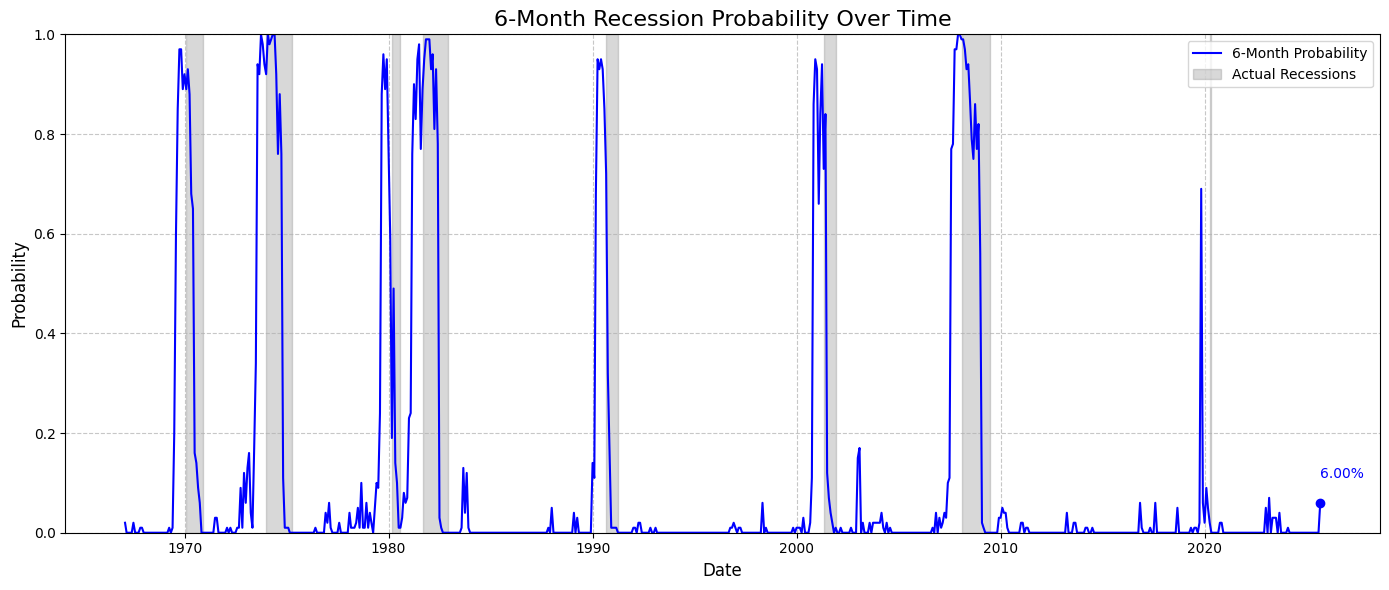

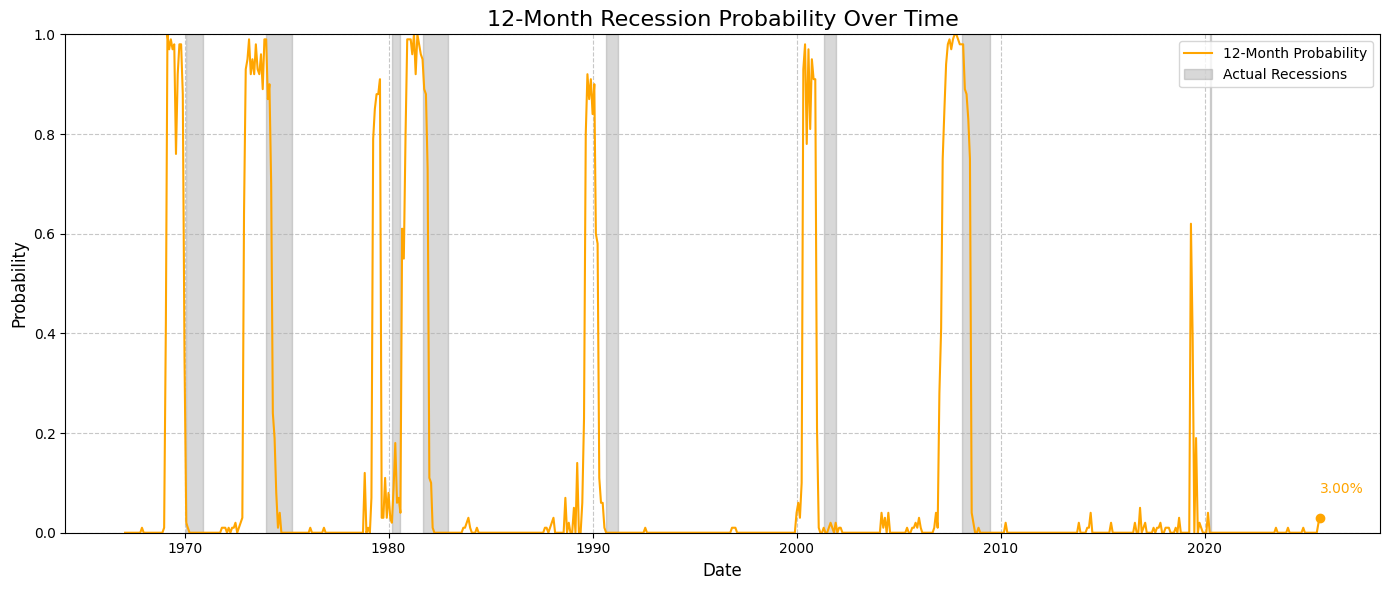

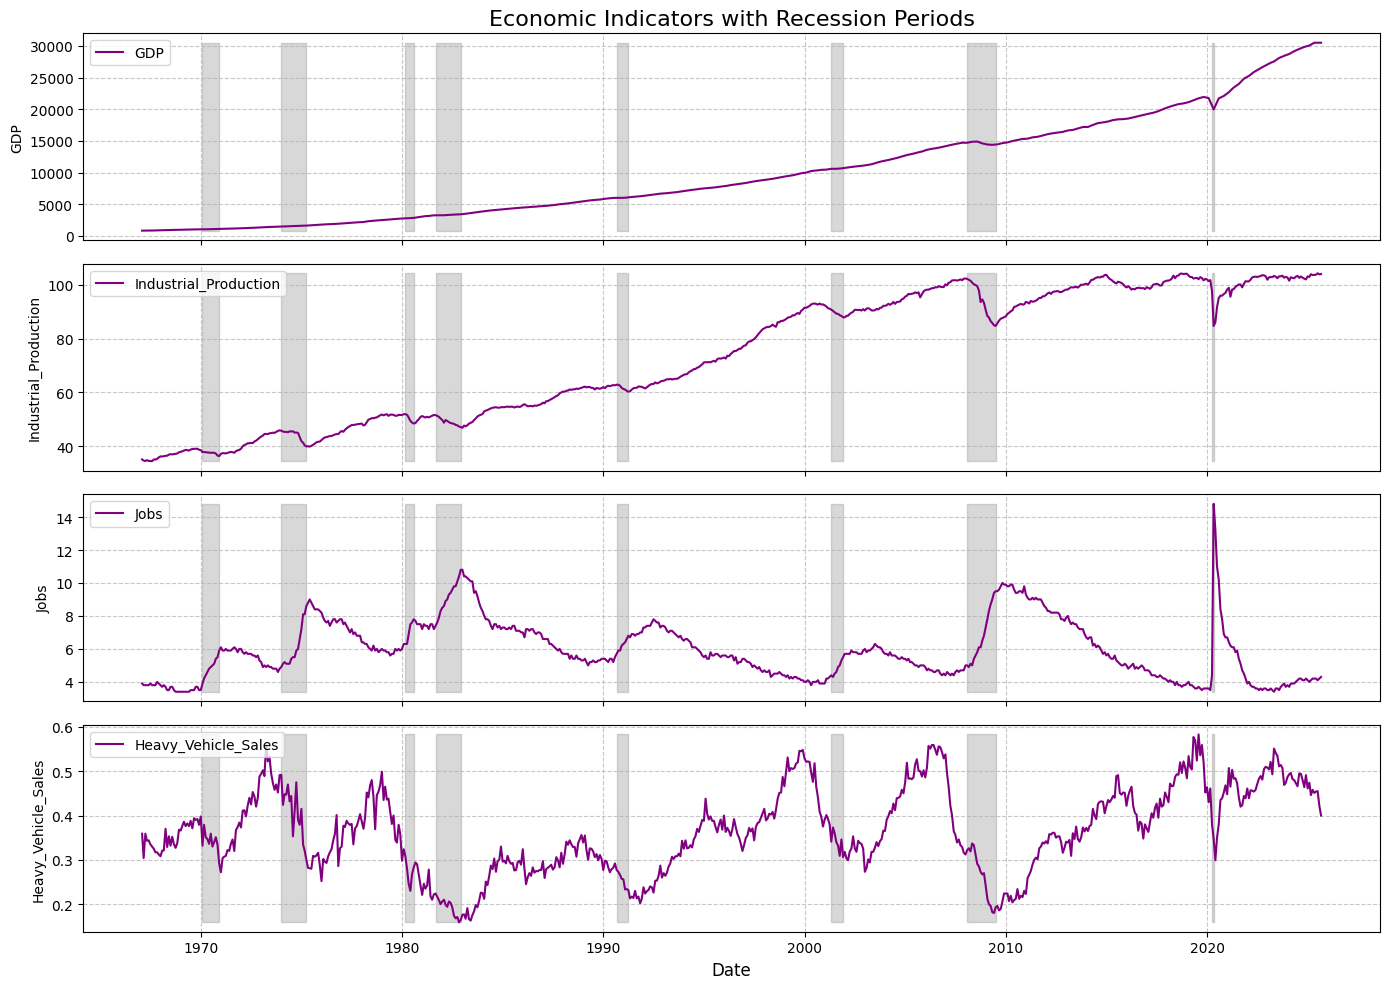

In [46]:
# Display results
print(f"\nPredicted probabilities from {df_full.index[-1]}:")
print(f"  Recession within 3 months: {latest_prob_3m:.2%}")
print(f"  Recession within 6 months: {latest_prob_6m:.2%}")
print(f"  Recession within 12 months: {latest_prob_12m:.2%}")

# Plotting recession probabilities separately for each horizon

# 3-Month Horizon Plot
plt.figure(figsize=(14, 6))
plt.plot(df_full.index, df_full['Recession_Prob_3M'], label='3-Month Probability', color='green')
recession_periods = df_full['Recession'] == 1
plt.fill_between(df_full.index, 0, 1, where=recession_periods, color='gray', alpha=0.3, label='Actual Recessions')
plt.title('3-Month Recession Probability Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.scatter(df_full.index[-1], latest_prob_3m, color='green', zorder=5)
plt.text(df_full.index[-1], latest_prob_3m + 0.05, f'{latest_prob_3m:.2%}', color='green')
plt.tight_layout()
plt.show()

# 6-Month Horizon Plot
plt.figure(figsize=(14, 6))
plt.plot(df_full.index, df_full['Recession_Prob_6M'], label='6-Month Probability', color='blue')
plt.fill_between(df_full.index, 0, 1, where=recession_periods, color='gray', alpha=0.3, label='Actual Recessions')
plt.title('6-Month Recession Probability Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.scatter(df_full.index[-1], latest_prob_6m, color='blue', zorder=5)
plt.text(df_full.index[-1], latest_prob_6m + 0.05, f'{latest_prob_6m:.2%}', color='blue')
plt.tight_layout()
plt.show()

# 12-Month Horizon Plot
plt.figure(figsize=(14, 6))
plt.plot(df_full.index, df_full['Recession_Prob_12M'], label='12-Month Probability', color='orange')
plt.fill_between(df_full.index, 0, 1, where=recession_periods, color='gray', alpha=0.3, label='Actual Recessions')
plt.title('12-Month Recession Probability Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim(0, 1)
plt.scatter(df_full.index[-1], latest_prob_12m, color='orange', zorder=5)
plt.text(df_full.index[-1], latest_prob_12m + 0.05, f'{latest_prob_12m:.2%}', color='orange')
plt.tight_layout()
plt.show()

# Plot feature trends with recessions
fig, axes = plt.subplots(len(features), 1, figsize=(14, 10), sharex=True)
for i, feature in enumerate(features):
    axes[i].plot(df_full.index, df_full[feature], label=feature, color='purple')
    axes[i].fill_between(df_full.index, df_full[feature].min(), df_full[feature].max(),
                         where=recession_periods, color='gray', alpha=0.3)
    axes[i].set_ylabel(feature)
    axes[i].legend(loc='upper left')
    axes[i].grid(True, linestyle='--', alpha=0.7)
axes[0].set_title('Economic Indicators with Recession Periods', fontsize=16)
axes[-1].set_xlabel('Date', fontsize=12)
plt.tight_layout()
plt.show()

3-Month Horizon Feature Importance:


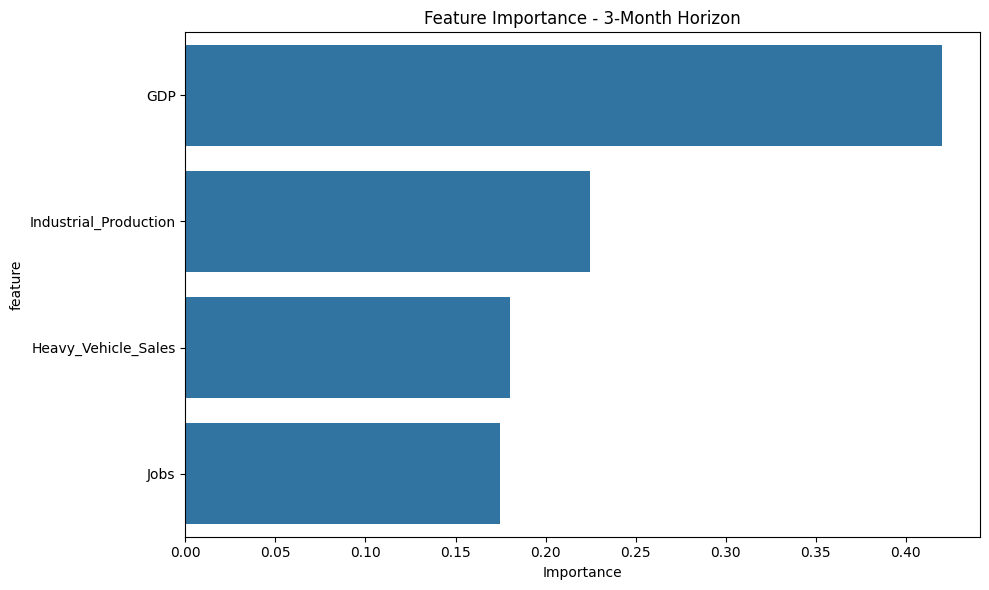


6-Month Horizon Feature Importance:


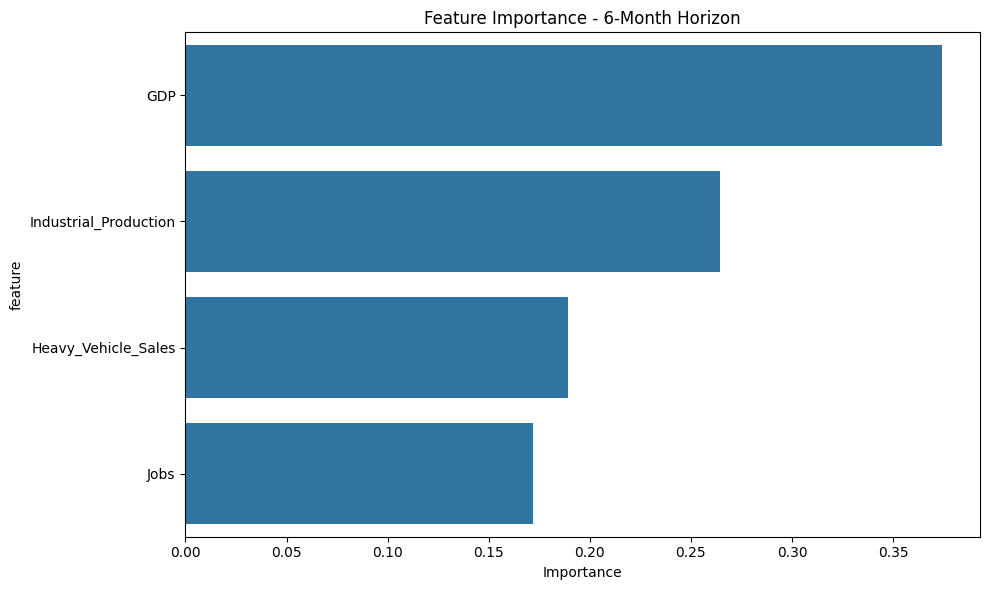


12-Month Horizon Feature Importance:


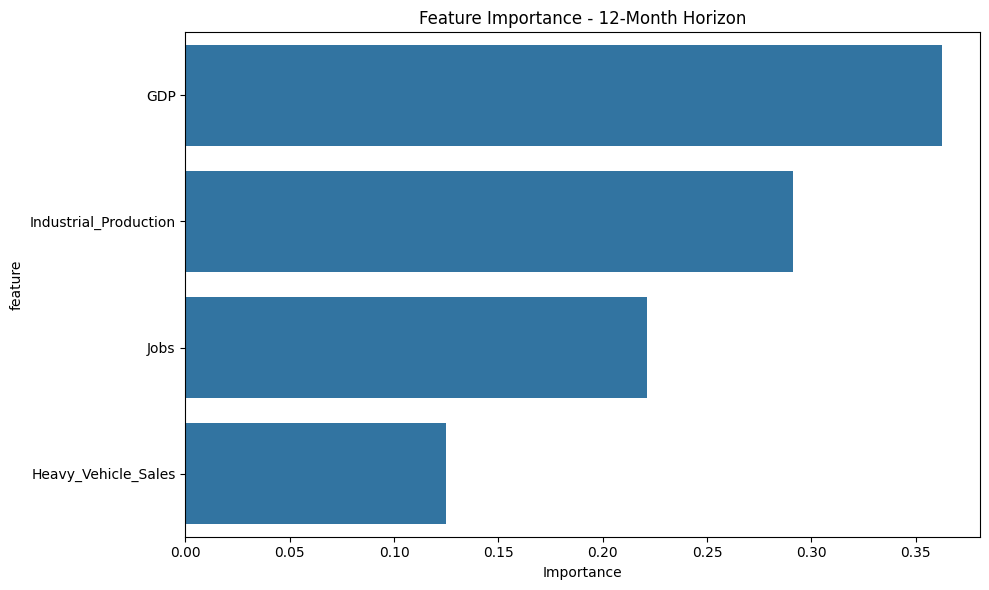

In [47]:
# Function to plot feature importance
def plot_feature_importance(model, features, title, top_n=10):
    # Get feature importances
    importance = model.feature_importances_
    
    # Create a dataframe
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # Plot top N features
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df.head(top_n), x='importance', y='feature')
    plt.title(f'Feature Importance - {title}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Analyze each model
print("3-Month Horizon Feature Importance:")
importance_3m = plot_feature_importance(model_3m, features, "3-Month Horizon")

print("\n6-Month Horizon Feature Importance:")
importance_6m = plot_feature_importance(model_6m, features, "6-Month Horizon")

print("\n12-Month Horizon Feature Importance:")
importance_12m = plot_feature_importance(model_12m, features, "12-Month Horizon")

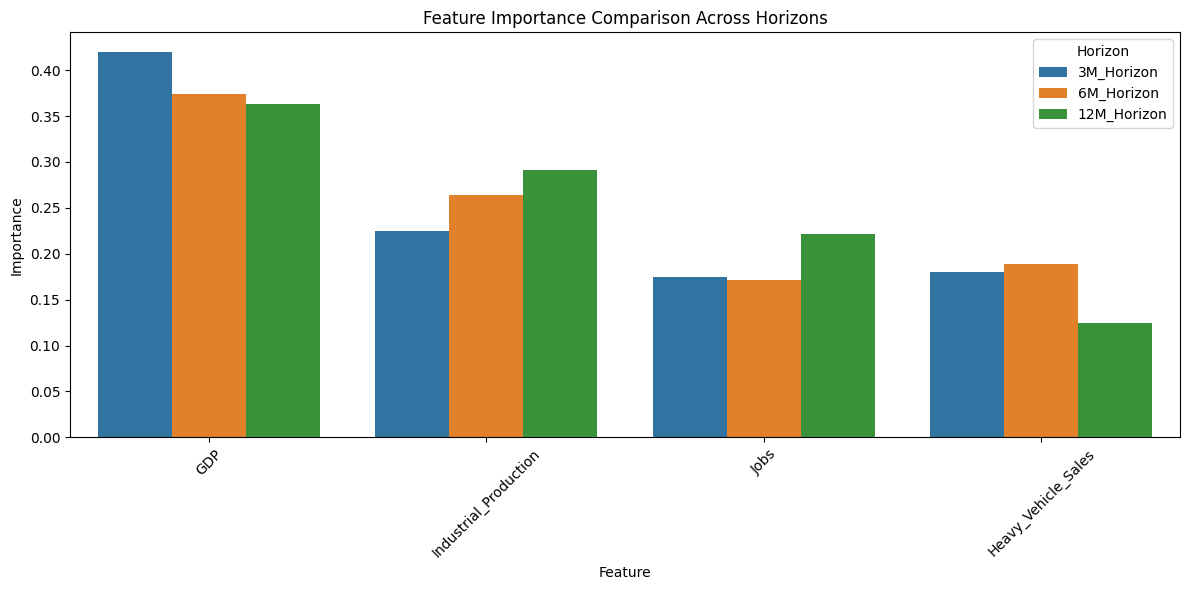

Feature Importance Comparison:
                 Feature  3M_Horizon  6M_Horizon  12M_Horizon
0                    GDP    0.420206    0.374271     0.362686
1  Industrial_Production    0.224915    0.264488     0.291286
2                   Jobs    0.174456    0.171879     0.221238
3    Heavy_Vehicle_Sales    0.180423    0.189363     0.124790


In [48]:
# Create a comprehensive comparison
comparison_df = pd.DataFrame({
    'Feature': features,
    '3M_Horizon': model_3m.feature_importances_,
    '6M_Horizon': model_6m.feature_importances_,
    '12M_Horizon': model_12m.feature_importances_
})

# Melt for plotting
comparison_melted = comparison_df.melt(id_vars='Feature', 
                                      var_name='Horizon', 
                                      value_name='Importance')

plt.figure(figsize=(12, 6))
sns.barplot(data=comparison_melted, x='Feature', y='Importance', hue='Horizon')
plt.title('Feature Importance Comparison Across Horizons')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Feature Importance Comparison:")
print(comparison_df)

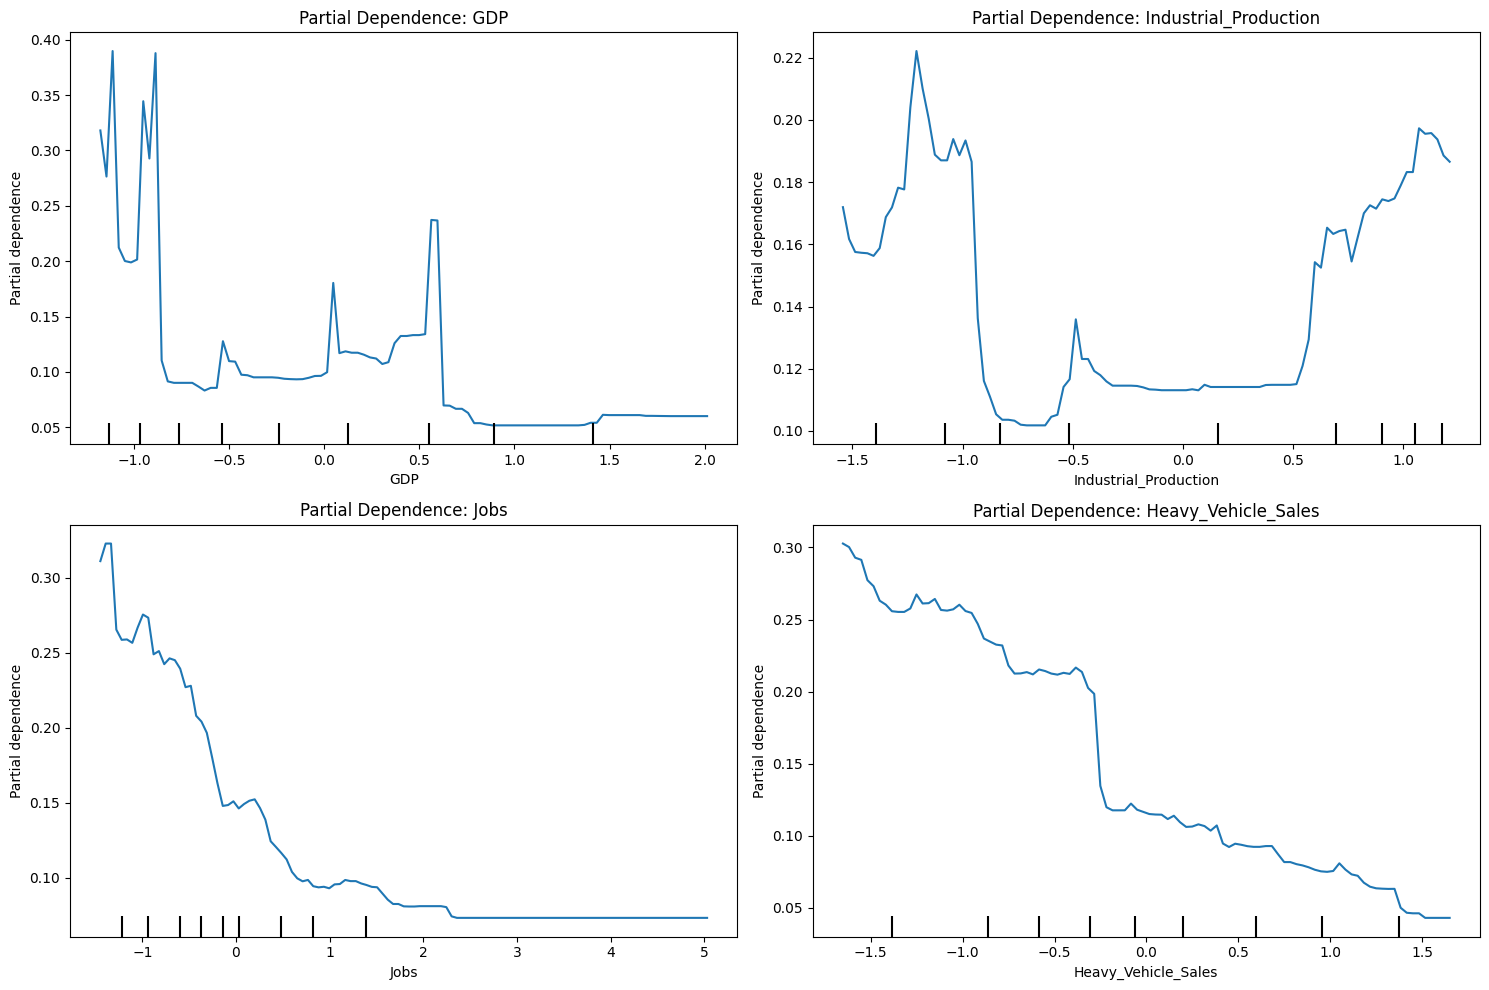

In [49]:
# Create partial dependence plots for each feature
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(features):
    # Use 3-month model as example (repeat for other horizons if needed)
    PartialDependenceDisplay.from_estimator(
        model_3m, 
        X_train_scaled_3m, 
        [i], 
        feature_names=features,
        ax=axes[i]
    )
    axes[i].set_title(f'Partial Dependence: {feature}')

plt.tight_layout()
plt.show()

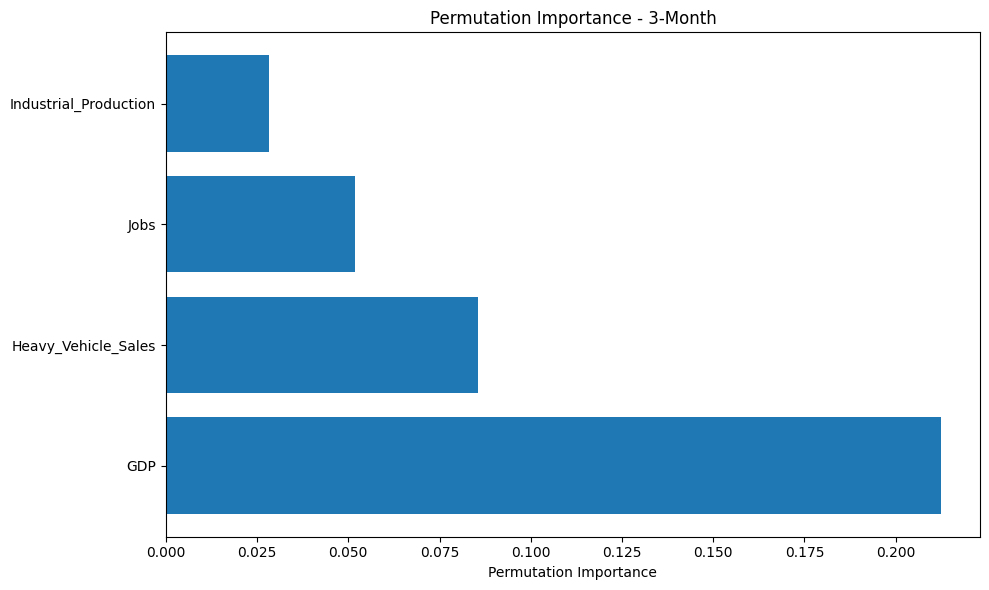

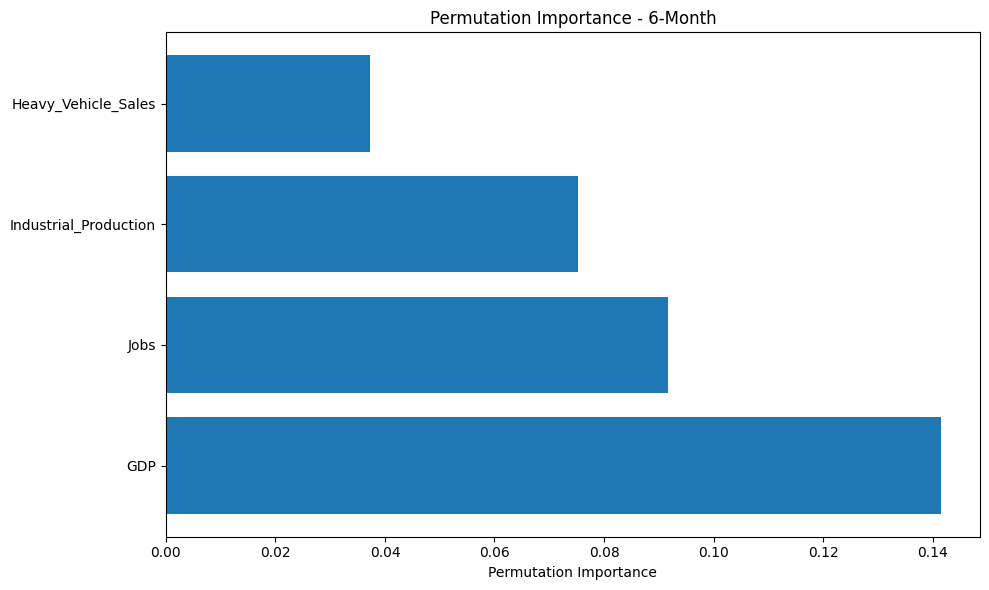

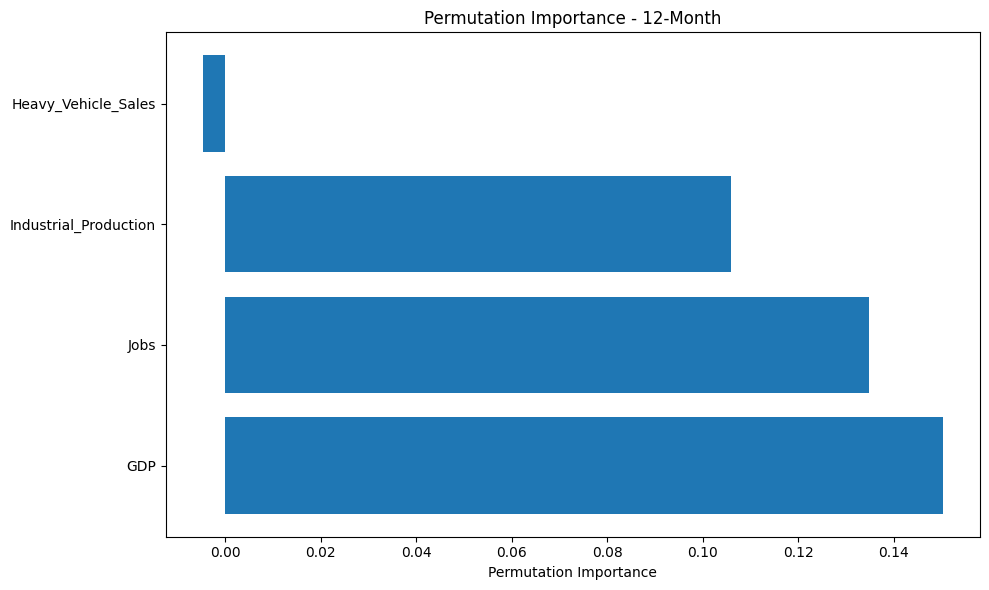

In [50]:
def calculate_permutation_importance(model, X_test, y_test, features, title):
    perm_importance = permutation_importance(
        model, X_test, y_test, 
        n_repeats=10, 
        random_state=42,
        scoring='roc_auc'  # or 'accuracy', 'f1', etc.
    )
    
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': perm_importance.importances_mean,
        'std': perm_importance.importances_std
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('Permutation Importance')
    plt.title(f'Permutation Importance - {title}')
    plt.tight_layout()
    plt.show()
    
    return importance_df

# Calculate permutation importance for each model
perm_3m = calculate_permutation_importance(model_3m, X_test_scaled_3m, y_test_3m, features, "3-Month")
perm_6m = calculate_permutation_importance(model_6m, X_test_scaled_6m, y_test_6m, features, "6-Month")
perm_12m = calculate_permutation_importance(model_12m, X_test_scaled_12m, y_test_12m, features, "12-Month")

In [59]:
from sklearn.metrics import roc_auc_score

def calculate_permutation_importance_with_auc(model, X_test, y_test, features, title):
    # Calculate original AUC
    original_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    
    perm_importance = permutation_importance(
        model, X_test, y_test, 
        n_repeats=10, 
        random_state=42,
        scoring='roc_auc'
    )
    
    importance_df = pd.DataFrame({
        'feature': features,
        'importance': perm_importance.importances_mean,  # AUC decrease amount
        'std': perm_importance.importances_std,
        'auc_decrease': perm_importance.importances_mean  # Same as importance
    }).sort_values('importance', ascending=False)
    
    print(f"Original {title} AUC: {original_auc:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['feature'], importance_df['importance'])
    plt.xlabel('AUC Decrease When Feature Randomized')
    plt.title(f'Permutation Importance - {title}\n(How much AUC decreases when feature is shuffled)')
    plt.tight_layout()
    plt.show()
    
    return importance_df

In [ ]:
def analyze_shap_values(model, X_train, X_test, features, title):
    # Create SHAP explainer
    explainer = shap.TreeExplainer(model)
    
    # Calculate SHAP values for test set
    shap_values = explainer.shap_values(X_test)
    
    # For binary classification, take the positive class
    if len(shap_values) == 2:
        shap_values = shap_values[1]  # Positive class
    
    # Summary plot
    shap.summary_plot(shap_values, X_test, feature_names=features, title=f'SHAP Summary - {title}')
    
    # Feature importance plot
    shap.summary_plot(shap_values, X_test, feature_names=features, plot_type="bar", title=f'SHAP Feature Importance - {title}')
    
    return shap_values

# Analyze SHAP values for each model
shap_3m = analyze_shap_values(model_3m, X_train_scaled_3m, X_test_scaled_3m, features, "3-Month")
shap_6m = analyze_shap_values(model_6m, X_train_scaled_6m, X_test_scaled_6m, features, "6-Month")
shap_12m = analyze_shap_values(model_12m, X_train_scaled_12m, X_test_scaled_12m, features, "12-Month")